In [26]:
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.stats import t as student_t
from scipy import integrate
from scipy.stats import norm
from sklearn.metrics import adjusted_rand_score  
import matplotlib.pyplot as plt
import math
from typing import Callable, Tuple, List, Dict, Literal

In [16]:
from statsmodels import robust 

In [2]:
import matplotlib.pyplot as plt
import pandas as pd 

# I- Dynamic programming functions

In [3]:

QuadPiece = Tuple[float, float, float, float, float, int]
#quadpiece is a tuple containing:
#first float a = left bound of the interval
#second flat b: right bound of the interval
#3 other floats A,B,C = coefficients of the quadratic polynom on interval [a,b]: AX^2+BX=c 
#last int tau = index of last changepoint 


#algorithm 2 from appendix D 
def rfpop_algorithm2_add_Qstar_and_gamma(Qstar_pieces: List[QuadPiece], 
                                         #Q_star est représenté sous forme [ (a1,b1,A1,B1,C1,tau1), (a2,b2,A2,B2,C2,tau2), ..., ]
                                         gamma_pieces: List[QuadPiece]):

    out: List[QuadPiece] = []
    i = 0
    j = 0
    while i < len(Qstar_pieces) and j < len(gamma_pieces):
        pa, pb, pA, pB, pC, p_tau = Qstar_pieces[i]
        ga, gb, gA, gB, gC, g_tau = gamma_pieces[j]

        #new interval 
        a = max(pa, ga)
        b = min(pb, gb)
        
        # sum of Q_star and gamma on the new interval
        newA = pA + gA
        newB = pB + gB
        newC = pC + gC
        # tau comes from Q* (p_tau) 
        out.append((a, b, newA, newB, newC, p_tau))
        # avancer indices selon bornes
        if abs(b - pb) < 1e-12:
            i += 1
        if abs(b - gb) < 1e-12:
            j += 1
        # to avoid infinite loop
        if (i < len(Qstar_pieces) and j < len(gamma_pieces)) and a >= b - 1e-14 and abs(b - Qstar_pieces[i][1]) > 1e-12 and abs(b - gamma_pieces[j][1]) > 1e-12:
            break
    # to do as they say on page 12 and merge identical neighbouring intervals
    if not out:
        return []
    merged: List[QuadPiece] = [out[0]]
    for pc in out[1:]:
        a,b,A,B,C,tau = pc
        ma,mb,mA,mB,mC,mtau = merged[-1]
        if (abs(A - mA) < 1e-14 and abs(B - mB) < 1e-14 and abs(C - mC) < 1e-9 and tau == mtau and abs(a - mb) < 1e-9):
            merged[-1] = (ma, b, mA, mB, mC, mtau)
        else:
            merged.append(pc)
    return merged



In [4]:
#algorithm 3 from pseudocode 
def rfpop_algorithm3_min_over_theta(Qt_pieces: List[QuadPiece]):
    best_val = float('inf')
    best_tau = 0
    for (a,b,A,B,C,tau) in Qt_pieces:
        # computing min of Q_t(theta) over segment (a,b]
        if abs(A) < 1e-16:
            #if the coefficient associated with x^2 of the quadratic function is =0 then the function is linear (B!=0) or constant (B=0)
            #hence in this case min value of Q_t(theta) is on the boundaries of the segment
            left = a + 1e-12 #because segment does not contain a 
            right = b
            vleft = A*left*left + B*left + C
            vright = A*right*right + B*right + C
            theta_star = left if vleft <= vright else right
        else: #if A!=0 then Q_t(theta) =A theta^2 + B theta + C on segment (a,b] 
            #so minimizer is -B/2A   (each quadratic is assumed convex, not concave so not a maximizer)
            theta_star = -B / (2.0 * A)
            #we need to ensure the minimizer is in (a,b]
            if theta_star <= a: 
                theta_star = a + 1e-12
            elif theta_star > b:
                theta_star = b
        val = A*theta_star*theta_star + B*theta_star + C
        if val < best_val:
            best_val = val
            best_tau = tau
    return float(best_val), int(best_tau)

In [5]:
#algorithm 4

def rfpop_algorithm4_prune_compare_to_constant(Qt_pieces: List[QuadPiece],
                                               Qt_val: float, #Qt_val + beta = the constant C in appendix
                                               beta: float,
                                               t_index_for_new: int):
   
    thr = Qt_val + beta
    out: List[QuadPiece] = []

    #goes through the Nt intervals of Qt
    for (a,b,A,B,C,tau) in Qt_pieces:
        #finds the roots of Q_t(x) - C ie the roots of A x^2 + B x + (C - thr) = 0 on [a,b]
        # BEWARE: source of confuction: thr is the equivalent of the constant C in the pseudocode of the paper
        # C is the last coefficient of the quadratic function, not the constant C defined in the pseudocode 
        roots: List[float] = []
        if abs(A) < 1e-16:
            # if the quadratic function is linear or constant: B x + (C - thr) = 0
            if abs(B) > 1e-16:
                x = -(C - thr) / B
                #we need to ensure root x is in interval [a,b] otherwise we don't care about it 
                if x + 1e-12 >= a and x - 1e-12 <= b:
                    x_clamped = max(min(x, b), a) #to ensure the root is indeed within the interval and have no problems of numerical errors later: we need to sort the roots it could do weird things later if we don't do that
                    roots.append(x_clamped)
        else:
            #if the function is indeed quadratic we compute delta and roots 
            D = B*B - 4.0*A*(C - thr)
            if D >= -1e-14:
                D = max(D, 0.0)
                sqrtD = math.sqrt(D)
                x1 = (-B - sqrtD) / (2.0*A)
                x2 = (-B + sqrtD) / (2.0*A)
                for x in (x1, x2):
                    if x + 1e-12 >= a and x - 1e-12 <= b:
                        x_clamped = max(min(x, b), a)
                        # avoid duplicates if delta D = 0 we get 2 times the same root 
                        if not any(abs(x_clamped - r) < 1e-9 for r in roots):
                            roots.append(x_clamped)
        roots.sort()
        # create vector [a, r1, r2,  b]
        breaks = [a] + roots + [b]
        for k in range(len(breaks)-1):
            lo = breaks[k]
            hi = breaks[k+1]
            mid = (lo + hi) / 2.0
            #here we evaluate the polynom A*mid*mid + B*mid + C - thr on each subsegment [a,root_1], [root_1,root_2],[root_2,b]
            #on each of these subsegment this polynom has the same sign as each bound of a subsegment is a root 
            #so we can pick an arbitrary value like the middle to see the sign of the polynom on this subsegment
            val_mid = A*mid*mid + B*mid + C - thr 

            #if polynom is negative then Q_t(theta)<constant so we keep Q_t(theta) = A*theta^2 + B*theta + C
            if val_mid <= 1e-12:
                # keep Q_t on this subsegment
                out.append((lo, hi, A, B, C, tau))
            else:
                # keep constant thr in this subsegment and set a changepoint at t_index_for_new 
                out.append((lo, hi, 0.0, 0.0, thr, t_index_for_new))
    # fusionner adjacences égales
    if not out:
        return []
    merged: List[QuadPiece] = [out[0]]
    for pc in out[1:]:
        a,b,A,B,C,tau = pc
        ma,mb,mA,mB,mC,mtau = merged[-1]
        if (abs(A - mA) < 1e-14 and abs(B - mB) < 1e-14 and abs(C - mC) < 1e-9 and tau == mtau and abs(a - mb) < 1e-9):
            merged[-1] = (ma, b, mA, mB, mC, mtau)
        else:
            merged.append(pc)
    return merged


In [6]:
#algorithm 1
def rfpop_algorithm1_main(y: List[float], gamma_builder, beta: float):

    y_arr = np.asarray(y, dtype=float)
    n = len(y_arr)

    lo = float(np.min(y_arr)) - 1.0 #we add -1 and +1 to ensure there is no numeric problem with python approximations for foats 
    hi = float(np.max(y_arr)) + 1.0
    Qstar = [(lo, hi, 0.0, 0.0, 0.0, 0)]  # Q*_1
    cp_tau = [0] * n
    Qt_vals = [0.0] * n
    for t_idx in range(n):
        # Sub-routine 2 : Qt = Q*_t + gamma(y_t)
        gamma_pcs = gamma_builder(float(y_arr[t_idx]), t_idx)
        Qt_pcs = rfpop_algorithm2_add_Qstar_and_gamma(Qstar, gamma_pcs)
        # Sub-routine 3 : min over theta Qt
        Qt_val, tau_t = rfpop_algorithm3_min_over_theta(Qt_pcs)
        cp_tau[t_idx] = tau_t
        Qt_vals[t_idx] = Qt_val
        # Sub-routine 4 : compute Q*_{t+1}
        Qstar = rfpop_algorithm4_prune_compare_to_constant(Qt_pcs, Qt_val, beta, t_idx)
    return cp_tau, Qt_vals, Qstar



In [7]:

QuadPiece = Tuple[float, float, float, float, float, int]
INF = 1e18  # borne pratique pour "infty"
EPS = 1e-12

def gamma_builder_L2(y: float, tau_for_new: int) -> List[QuadPiece]:
    """
    gamma(y,theta) = (y - theta)^2 = theta^2 - 2*y*theta + y^2
    Single quadratic piece on (-INF, INF].
    """
    A = 1.0
    B = -2.0 * y
    C = y * y
    return [(-INF, INF, A, B, C, tau_for_new)]

def gamma_builder_biweight(y: float, K: float, tau_for_new: int) -> List[QuadPiece]:
    """ :
      gamma(y,theta) = (y-theta)^2   if |y-theta| <= K
                      = K^2         otherwise
    Can be defined as 3 different quadratic functions over 3 segments :
      (-INF, y-K]       : constant K^2
      (y-K, y+K]        : quadratic (y-theta)^2
      (y+K, INF)        : constant K^2
    """
    A_q = 1.0
    B_q = -2.0 * y
    C_q = y * y
    constC = float(K * K)
    return [
        (-INF, y - K, 0.0, 0.0, constC, tau_for_new),
        (y - K, y + K, A_q, B_q, C_q, tau_for_new),
        (y + K, INF, 0.0, 0.0, constC, tau_for_new)
    ]


def gamma_builder_huber(y: float, K: float, tau_for_new: int) -> List[QuadPiece]:
    """
    Huber loss with threshold K:
      gamma(y,theta) = (y-theta)^2                     if |y-theta| <= K
                      = 2*K*|y-theta| - K^2           if |y-theta| > K
    
    Can be defined as 3 quadratic functions over 3 segments  
    (-INF, y-K] :  2*K*(y-theta) - K^2 = -2K*theta + (2K*y - K^2)
    (y-K, y+K]: (y-theta)^2 = theta^2 - 2y theta + y^2
    (y+K, INF): 2*K*(theta-y) - K^2 = 2K*theta + (-2K*y - K^2)
    """
    # central quadratic
    A_q = 1.0
    B_q = -2.0 * y
    C_q = y * y
    # left linear: B_left * theta + C_left  where B_left = -2K, C_left = 2K*y - K^2
    B_left = -2.0 * K
    C_left = 2.0 * K * y - K * K
    # right linear: B_right * theta + C_right where B_right = 2K, C_right = -2K*y - K^2
    B_right = 2.0 * K
    C_right = -2.0 * K * y - K * K
    return [
        (-INF, y - K, 0.0, B_left, C_left, tau_for_new),   # linear = A=0
        (y - K, y + K, A_q, B_q, C_q, tau_for_new),       # quadratic
        (y + K, INF, 0.0, B_right, C_right, tau_for_new) # linear = A=0
    ]

def gamma_builder_L1(y: float, tau_for_new: int) -> List[QuadPiece]:
    """
    L1 loss: gamma(y,theta) = |y - theta|
    Piecewise-linear
      (-INF, y) :  y - theta = (-1)*theta + y
      (y, INF): theta - y = (+1)*theta + (-y)

    """
    # left piece: (-INF, y] -> -theta + y  => A=0, B=-1, C=y
    # right piece: (y, INF] -> theta - y  => A=0, B=1,  C=-y
    return [
        (-INF, y, 0.0, -1.0, float(y), tau_for_new),
        (y, INF, 0.0,  1.0, float(-y), tau_for_new)
    ]


## II - Data for experiments 

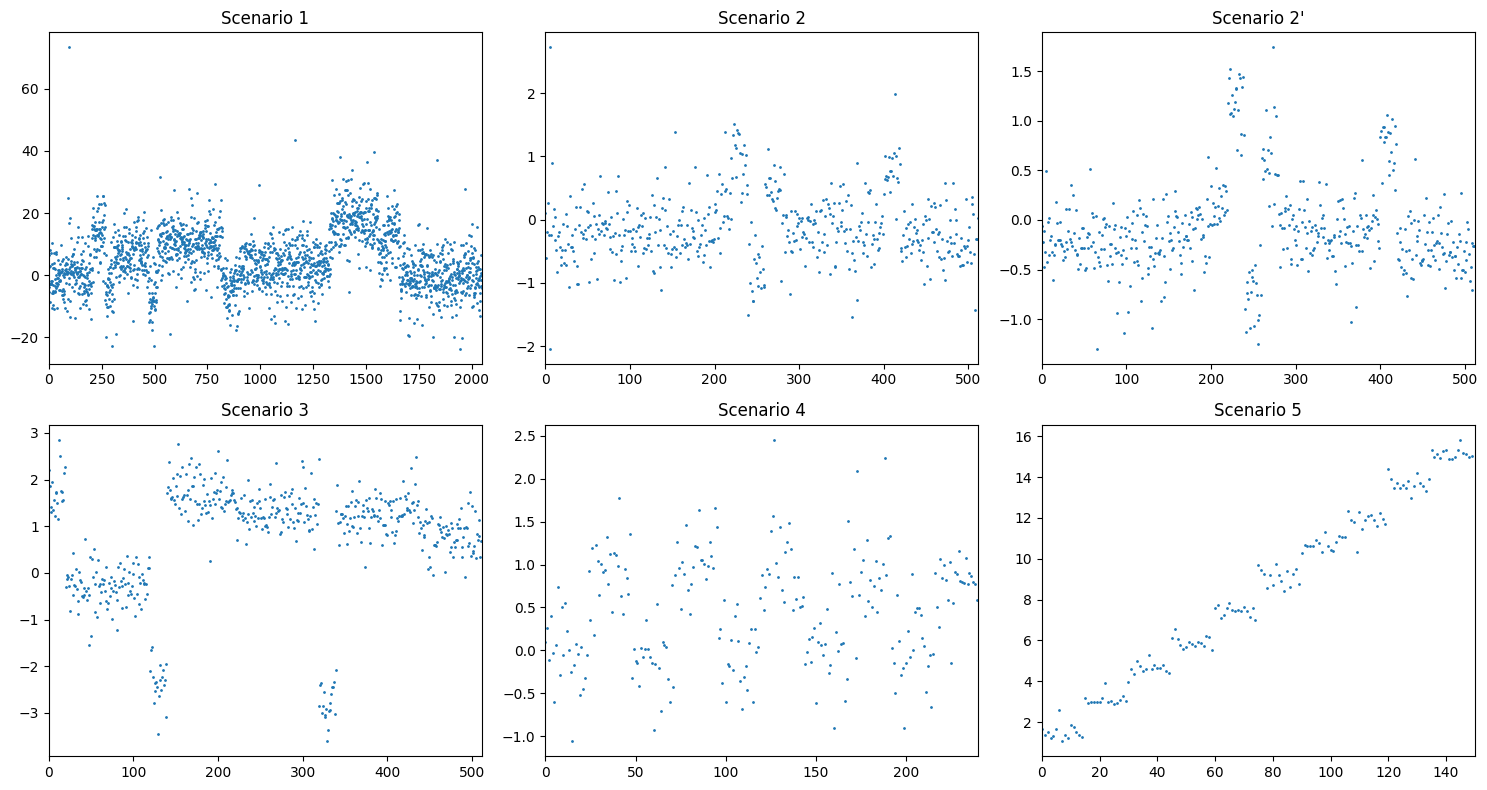

In [42]:


def generate_scenarios():

    np.random.seed(42) 

    # Fonction auxiliaire pour le bruit t-student
    def t_noise(n, df=5, sigma=1.0):
        return np.random.standard_t(df, size=n) * sigma

    #scenario 1
    n1 = 2048
    t = np.arange(n1) / n1
    pos = np.array([0.1, 0.13, 0.15, 0.23, 0.25, 0.40, 0.44, 0.65, 0.76, 0.78, 0.81])
    h = np.array([4, -5, 3, -4, 5, -4.2, 2.1, 4.3, -3.1, 2.1, -4.2])
    sig1 = np.zeros(n1)
    for p, hi in zip(pos, h):
        sig1[int(p * n1):] += hi
    sig1 = sig1 * 3.5 
    y1 = sig1 + t_noise(n1, df=5, sigma=5.0) 

    #Scenario 2
    n2 = 512
    sig2 = np.zeros(n2)
    segments_fms = [
        (0, 200, -0.2), (200, 220, 0.2), (220, 240, 1.2), (240, 260, -0.8),
        (260, 280, 0.5), (280, 400, -0.1), (400, 420, 0.8), (420, 512, -0.3)
    ]
    for start, end, val in segments_fms:
        sig2[start:end] = val
    y2 = sig2 + t_noise(n2, df=5, sigma=0.3)


    # --- Scenario 2'
    # same signal but less noise
    y2_prime = sig2 + t_noise(n2, df=5, sigma=0.2)

    #Scenario 3
    # short and long segments
    n3 = 512
    sig3 = np.zeros(n3)
    curr = 0
    mu = 0
    #alternate randomly between long and short segments 
    while curr < n3:
        length = np.random.choice([10, 20, 80, 100])
        val = np.random.normal(0, 2)
        end = min(curr + length, n3)
        sig3[curr:end] = val
        curr = end

    y3 = sig3 + t_noise(n3, df=5, sigma=0.3)


    #Scenario 4 saw tooth 
    n4 = 240
    sig4 = np.zeros(n4)
    n_teeth = 10
    len_tooth = n4 // n_teeth 
    for i in range(n_teeth):
        if i % 2 == 1:
            sig4[i*len_tooth : (i+1)*len_tooth] = 1.0
    y4 = sig4 + t_noise(n4, df=5, sigma=0.3)

    #Scenario 5: Stairs 
    n5 = 150
    sig5 = np.zeros(n5)
    n_steps = 10
    len_step = n5 // n_steps 
    for i in range(n_steps):
        sig5[i*len_step : (i+1)*len_step] = (i + 1) * 1.5
    # Bruit
    y5 = sig5 + t_noise(n5, df=5, sigma=0.3)

    return {
        "Scenario 1": y1,
        "Scenario 2": y2,
        "Scenario 2'": y2_prime,
        "Scenario 3": y3,
        "Scenario 4": y4,
        "Scenario 5": y5
    }


data = generate_scenarios()


fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

scenario_names = ["Scenario 1", "Scenario 2", "Scenario 2'", 
                    "Scenario 3", "Scenario 4", "Scenario 5"]

for i, name in enumerate(scenario_names):
    y = data[name]
    ax = axes[i]

    ax.plot(y, '.', markersize=2)
    ax.set_title(name)
    ax.set_xlim(0, len(y))
    

plt.tight_layout()
plt.show()

## III- Reproducing the experiments 

First we try arbitrary values for beta and K.

0 1280
1 6
2 5
3 7
4 3
5 11


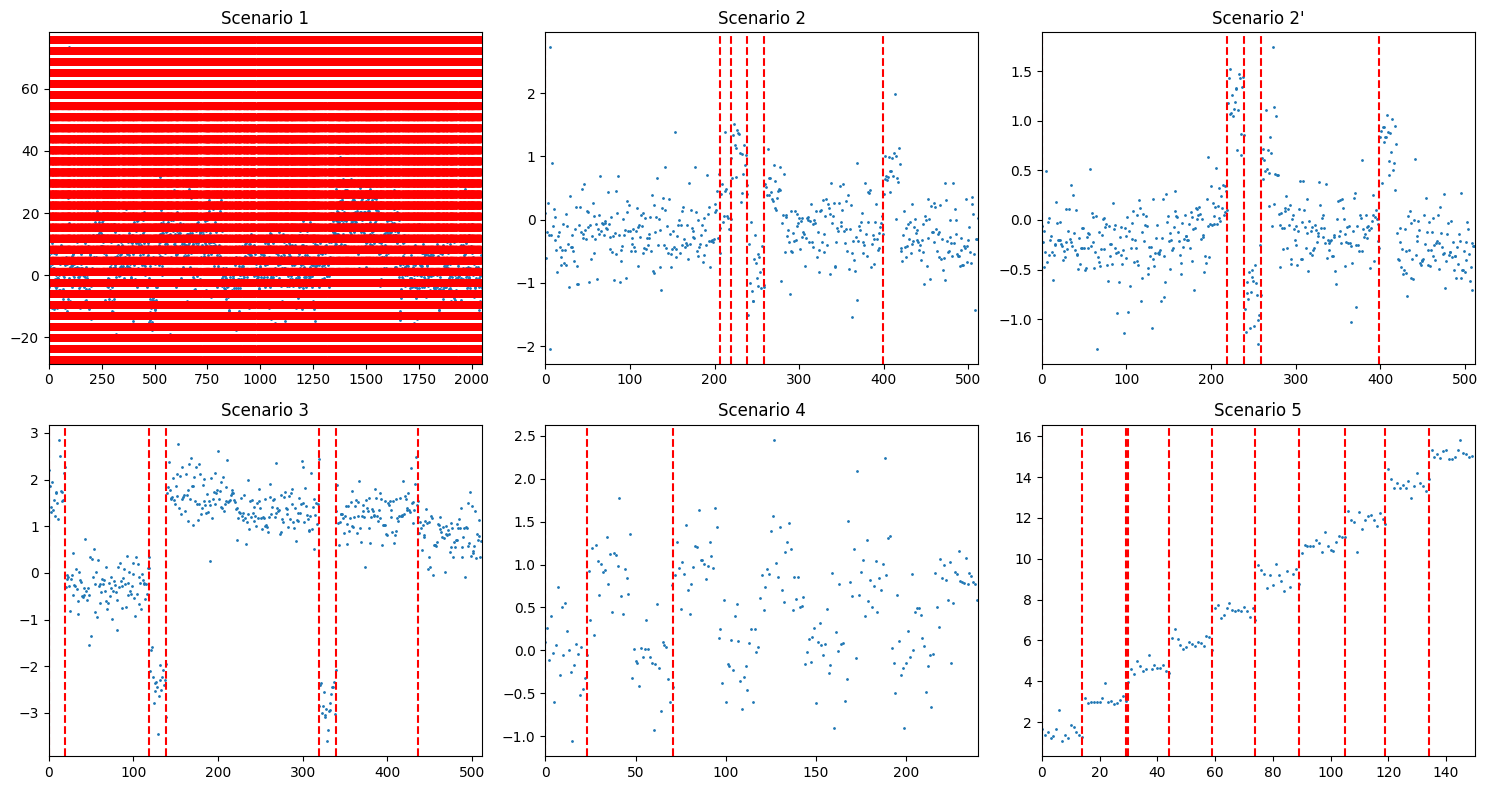

In [43]:
#first test: let's say we want beta/K >= n_data/K so we can set beta = n_data for each scenario to start with 
#we arbitrarly set K=10


fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

scenario_names = ["Scenario 1", "Scenario 2", "Scenario 2'", 
                    "Scenario 3", "Scenario 4", "Scenario 5"]

for i, name in enumerate(scenario_names):
    y = data[name]
    beta = 10
    K=2

    cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L2(y_t, t), beta)


    ax = axes[i]

    ax.plot(y, '.', markersize=2)
    changepoints = np.unique(cp_tau)
    print(i,len(changepoints))
    for cp in changepoints:
        
        # On trace une ligne rouge pointillée à chaque changepoint
        ax.axvline(x=cp, color='r', linestyle='--', label='Changepoint' if cp == changepoints[0] else "")
    ax.set_title(name)
    ax.set_xlim(0, len(y))
    

plt.tight_layout()
plt.show()

We see that it yields some weird results and too many changepoints for some scenarios so we should pick K and beta optimally as in the paper: 
$$K = \begin{cases}
                3 \hat \sigma \quad \text{for the biweight loss}, \\
                1.345 \hat \sigma \quad \text{for the huber loss}
            \end{cases} $$


Where $\hat \sigma$ is the median absolute deviation of the differenced time series. 


$$ \beta = 2 \hat \sigma^2\text{log}(n) \mathbb E(\phi(Z)^2)$$

Where $\phi$ is the gradient of the loss function and $Z \sim \mathcal N(0,1)$

In [44]:
#function to compute parameter K
def compute_loss_bound_K(y,
             loss: Literal['huber','biweight']):
    ys =pd.Series(y)
    mad = robust.mad(ys.diff().dropna())
    if loss == "biweight":
        return 3*mad
    elif loss == 'huber':
        return 1.345*mad 



#functions necessary to compute optimal beta according to schwarz information criteria 
#we now need to introduce a few auxiliary functions to compute the optimal beta from the paper:
#indeed we need to compute E(phi(Z)^2) where phi is the gradient of the loss function used: this implies doing numerical approximations

# Huber loss gradient definition for integration
def huber_gradient(z, K):
    return z if abs(z) <= K else math.copysign(K, z)

# biweight loss gradient definition for integration
def biweight_gradient(z, K):
    return z if abs(z) <= K else 0


# function to integrate that will be used to approximate E(phi(Z)^2)
def integrand_phi2(phi_func, z, K):
    return (phi_func(z, K)**2) * norm.pdf(z)



# def compute_E_phi2(phi_func, #either huber_gradient or biweight_gradient 
#                    K):
#     E_phi2, _ = integrate.quad(lambda z: integrand_phi2(phi_func, z, K), -np.inf, np.inf,
#                                 epsabs=1e-9, epsrel=1e-9, limit=200)
    
#     return float(E_phi2)

def compute_penalty_beta(y,
                         loss: Literal['huber','biweight','l2','l1']
                         ):
    
    """
    page 16 of the paper: optimal beta according to schwarz information criteria is beta = 2 \hat{\sigma}^2 log(n) E(phi(Z)^2)
    where:
    \hat{\sigma} = median absolute deviation of the differentiated time series y = estimator of variance of the noise
    n = length of time series 
    phi = gradient of the loss function used 
    Z = a N(0,I)

    for L2 loss p(z) = z^2/2, phi(z)=z so E(phi(Z)^2) = E(Z^2) = 1
    for huber and biweight loss, E(phi(Z)^2) is approximated numerically 
    for L1 loss we can't apply the formula of the paper as E(phi(Z)^2) = 0 so we arbitrarly pick beta = log(n)
    """
    ys =pd.Series(y)
    mad = robust.mad(ys.diff().dropna())

    if loss == 'l2':
        return 2*mad*mad*np.log(len(y))

    elif loss == 'huber':

        K = compute_loss_bound_K(y,'huber')

        E_phi2, _ = integrate.quad(lambda z: integrand_phi2(huber_gradient, z, K), -np.inf, np.inf,
                                epsabs=1e-9, epsrel=1e-9, limit=200)
        
        return 2*mad*mad*np.log(len(y))*float(E_phi2)
    
    elif loss == 'biweight':
        
        K = compute_loss_bound_K(y,'biweight')

        E_phi2, _ = integrate.quad(lambda z: integrand_phi2(biweight_gradient, z, K), -np.inf, np.inf,
                                epsabs=1e-9, epsrel=1e-9, limit=200)
        
        return 2*mad*mad*np.log(len(y))*float(E_phi2)
    
    elif loss == 'l1':
        return np.log(len(y))


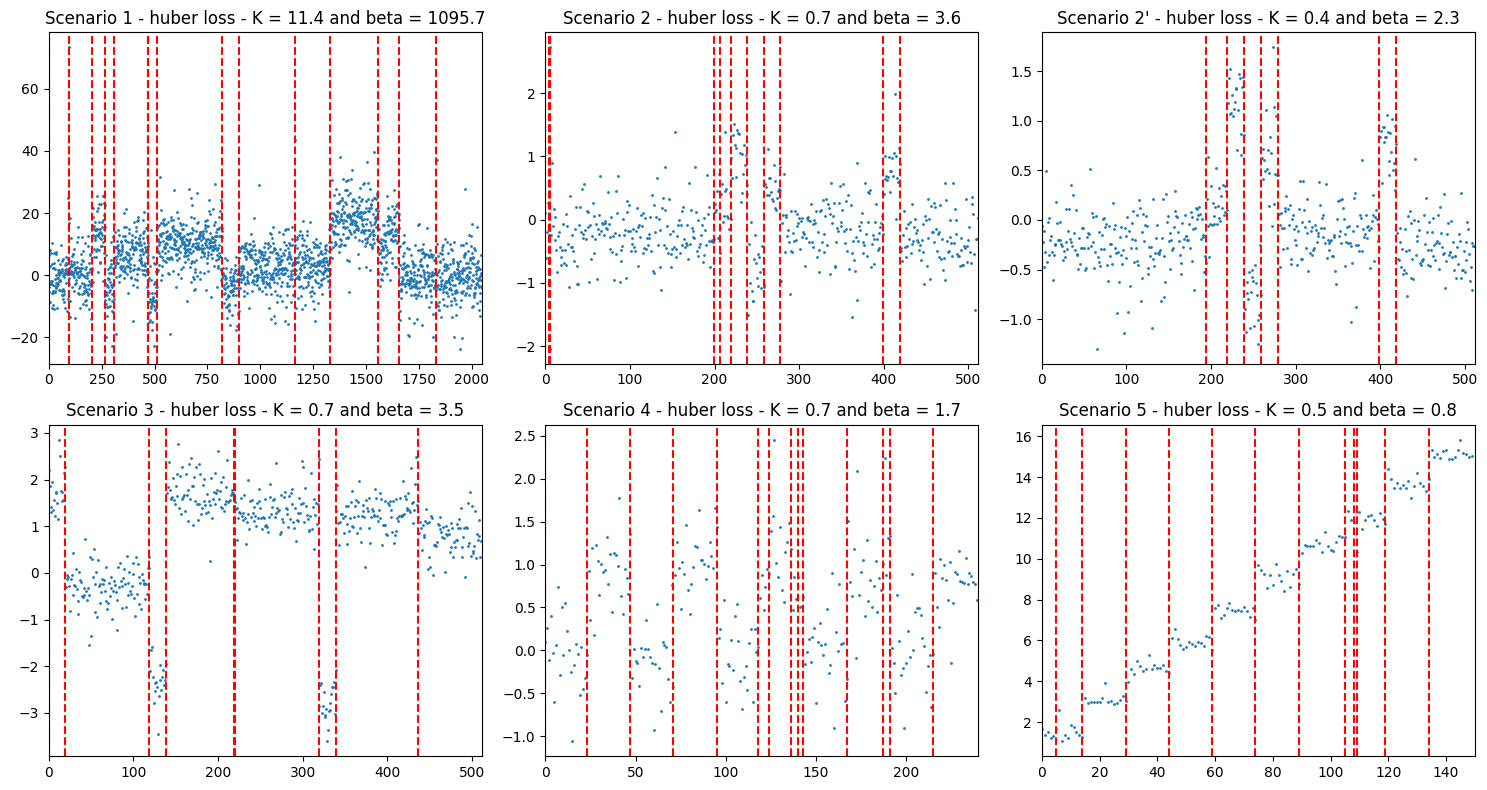

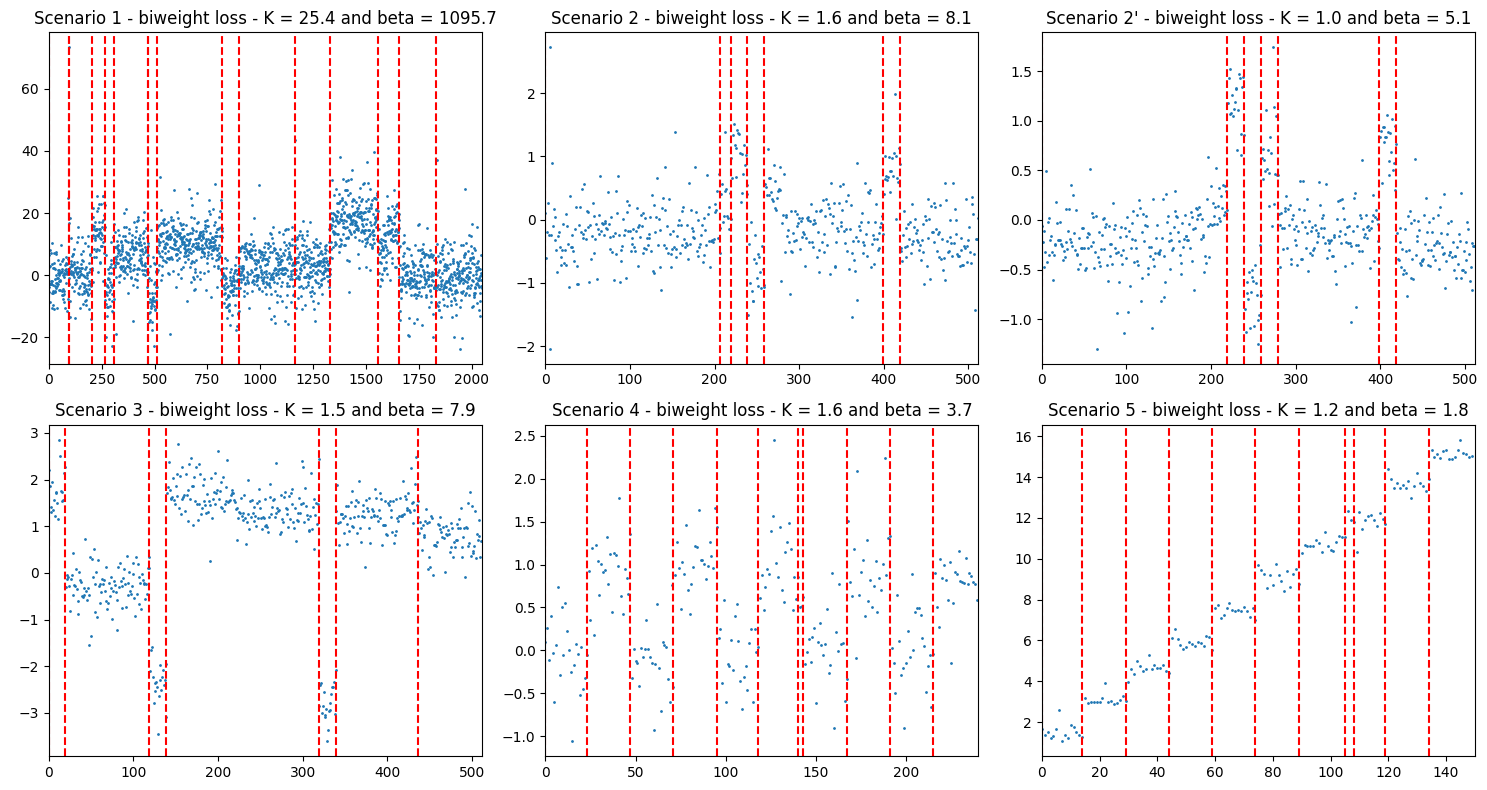

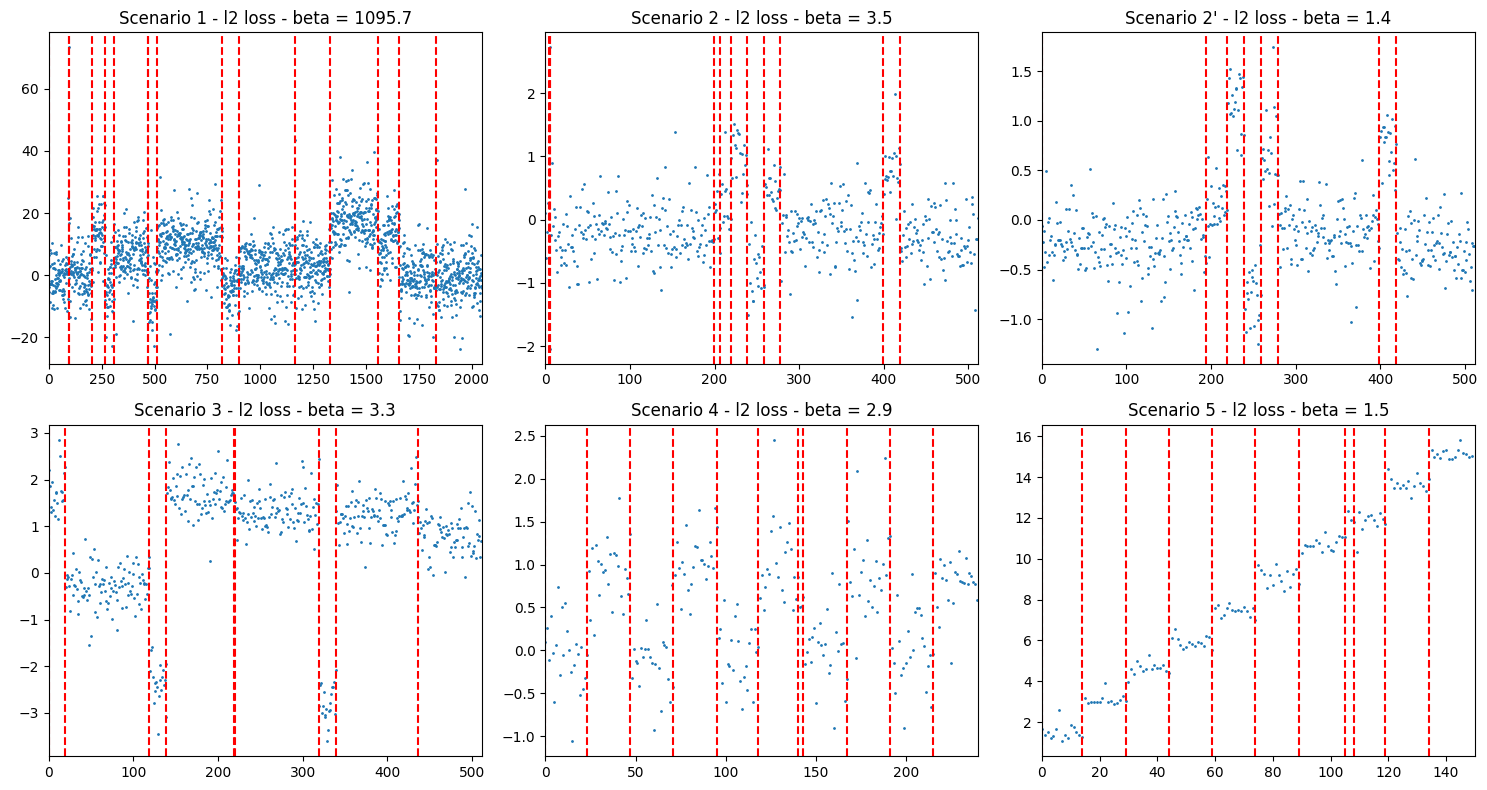

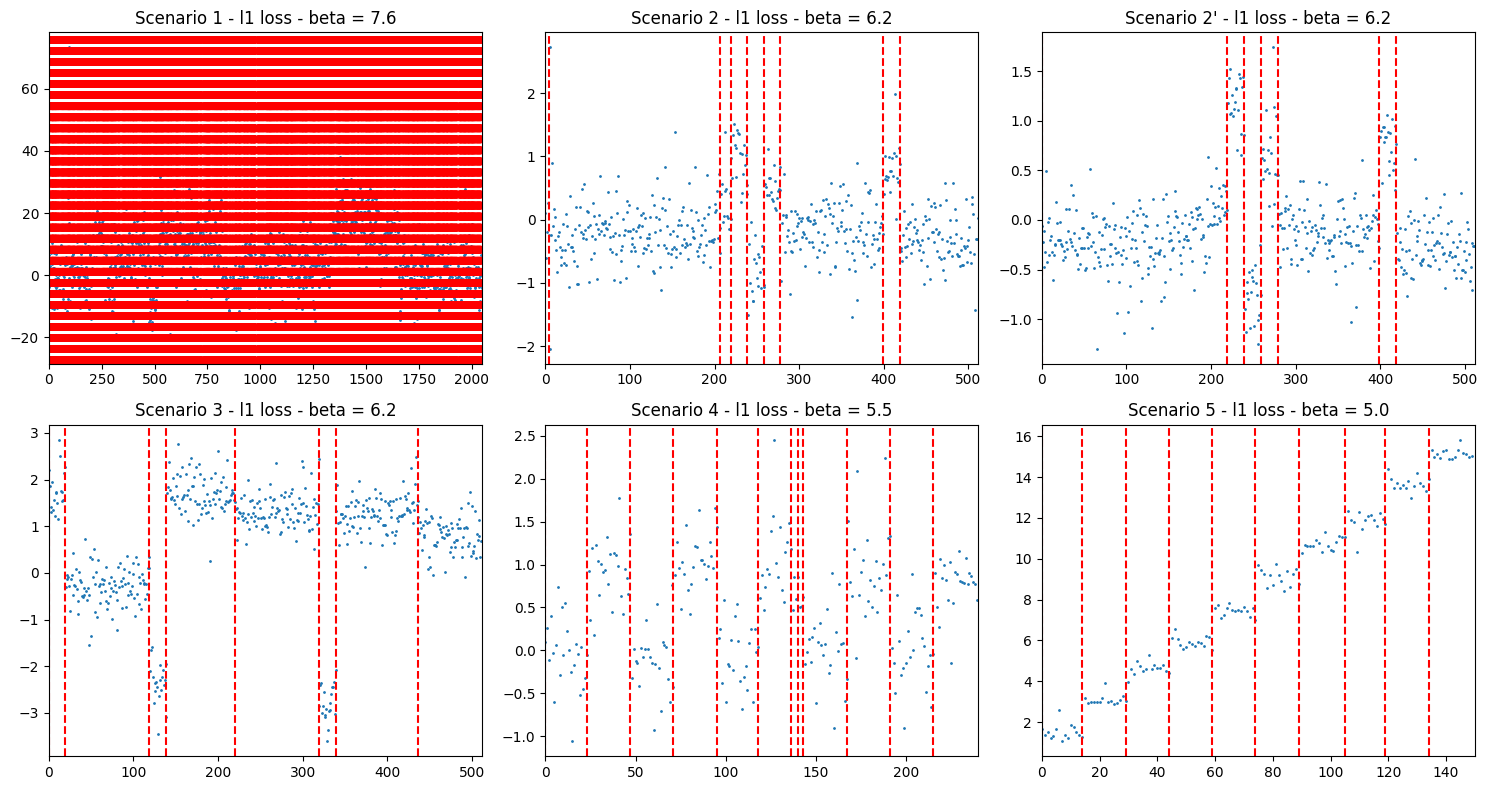

In [48]:

for loss in ['huber','biweight','l2','l1']:
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    axes = axes.flatten()



    scenario_names = ["Scenario 1", "Scenario 2", "Scenario 2'", 
                        "Scenario 3", "Scenario 4", "Scenario 5"]

    for i, name in enumerate(scenario_names):
        y = data[name]
        beta = compute_penalty_beta(y,loss)
        K=compute_loss_bound_K(y,loss)

        if K:
            if beta/K < len(y)/100:
                beta = K*len(y)/100


        cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_L2(y_t, t), beta)


        ax = axes[i]

        ax.plot(y, '.', markersize=2)
        changepoints = np.unique(cp_tau)
    
        for cp in changepoints:
            
            # On trace une ligne rouge pointillée à chaque changepoint
            ax.axvline(x=cp, color='r', linestyle='--', label='Changepoint' if cp == changepoints[0] else "")
        if not K:
            ax.set_title(f'{name} - {loss} loss - beta = {round(beta,1)}')
        else:
            ax.set_title(f'{name} - {loss} loss - K = {round(K,1)} and beta = {round(beta,1)}')
        ax.set_xlim(0, len(y))
        

    plt.tight_layout()
    plt.show()

To do: faire des plots pour voir comment évolue le nb de changepoint en fonction du nombre de points pour ces différents scénarios.

Comparer le choix du beta par cross validation vs par BIC pour voir avec quelles performances on a de meilleurs résultats

In [ ]:
# Exemple d'utilisation :
# def gamma_builder_biweight(y_t, tau_idx, K=3.0):
#     return [(-INF, y_t - K, 0.0, 0.0, K*K, tau_idx),
#             (y_t - K, y_t + K, 1.0, -2.0*y_t, y_t*y_t, tau_idx),
#             (y_t + K, INF, 0.0, 0.0, K*K, tau_idx)]
#
# y = [0.1, 0.0, 0.2, 5.0, 5.1, 5.2, 0.3, 0.2]
# beta = 2.0
# cp_tau, Qt_vals, Qstar_final = rfpop_algorithm1_main(y, lambda y_t, t: gamma_builder_biweight(y_t, t, K=1.0), beta)
# print("tau_t:", cp_tau)
